# Introduction
이번 대회는 브라질에서 3번째로 큰 보험사인 포르투 세구로(Porto Seguro)가 주최하며 운전자가 내년에 보험금 청구를 시작할 확률을 예측하는 과제를 안고 있다.


이 노트북은 Python 시각화 라이브러리 Plot.ly을 통해 일부 대화형 차트와 경쟁 데이터 분석을 제공하며, 
다른 사용자가 취하고 복제할 수 있는 통찰력과 아름다운 플롯을 제공하는 것을 목표로 합니다.
Plot.ly은 소프트웨어 회사 Flotly가 제공하는 주요 제품 중 하나이며, Python, R, Matlab, Node.js 등과 같은
풍부한 프로그래밍 언어와 도구 모음에 API를 제공하는 것을 전문으로 한다.


- 단순 수평 막대 그림 : 목표 변수 분포를 검사하는 데 사용됩니다.
- 상관 히트맵 : 여러 변수 간의 상관 관계 조사
- 산점도 : 랜덤 포레스트 및 그레디언트-부스트 모형에서 생성된 변수 중요도 비교
- 수직 막대 그림 : 내림차순으로 나열, 다양한 변수의 중요도
- 3D 산점도





이 노트의 주제는 다음과 같이 간략하게 요약할 수 있습니다.

1. 데이터 품질 검사 : 모든 결측값/Null 값 시각화 및 평가(-1인 값) = missingno


2. 변수 검사 및 필터링 : y변수에 대한 상관 관계 및 변수 상호 정보 그림. 이항, 범주형 및 기타 변수에 대한 검사입니다. = 수직막대그림, 히트맵


3. 학습 모델을 통한 변수 중요도 순위 지정: 학습 프로세스를 기반으로 변수 순위를 매기는 데 도움이 되는 랜덤 포레스트/그레이디언트 부스트 모델을 구축합니다.



# 정리

- float, int 히트맵

- 상호 정보 그림
0이면 독립, 높으면 일부 의존성 존재

이진(binary) - 0,1
- 수직막대그림


카테고리, 순위(ordinal)

- 랜덤포레스트의 변수중요도

- 그레이디언트 부스팅의 변수중요도


In [1]:
!pip install plotly==3.8.1

In [2]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

Let us load in the training data provided using Pandas:

In [3]:
train = pd.read_csv("./train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality checks

##### Null or missing values check



품질 검사의 일환으로, 다음과 같이 훈련 데이터 세트에 null 값이 있는지 빠르게 살펴보겠습니다.

In [5]:
# any() applied twice to check run the isnull check across all columns.
train.isnull().any().any()

False

Null 값 검사는 False를 반환하지만 데이터가 "-1 값은 관찰에서 피쳐가 누락되었음을 나타냄"으로 설명되기 때문에 이 사례가 종결되었음을 의미하지는 않습니다. 따라서 나는 포르투 세구로가 단순히 데이터에 있는 모든 null 값을 -1 값으로 대체한 것을 포괄적으로 수행했다고 본다. 이제 데이터에 결측값이 있는지 검사하겠습니다.


여기서는 값에 -1이 포함된 열을 확인할 수 있으며, 예를 들어 모든 -1을 null로 쉽게 바꿀 수 있습니다.

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

In [7]:
train_copy.isnull().sum()

id                     0
target                 0
ps_ind_01              0
ps_ind_02_cat        216
ps_ind_03              0
ps_ind_04_cat         83
ps_ind_05_cat       5809
ps_ind_06_bin          0
ps_ind_07_bin          0
ps_ind_08_bin          0
ps_ind_09_bin          0
ps_ind_10_bin          0
ps_ind_11_bin          0
ps_ind_12_bin          0
ps_ind_13_bin          0
ps_ind_14              0
ps_ind_15              0
ps_ind_16_bin          0
ps_ind_17_bin          0
ps_ind_18_bin          0
ps_reg_01              0
ps_reg_02              0
ps_reg_03         107772
ps_car_01_cat        107
ps_car_02_cat          5
ps_car_03_cat     411231
ps_car_04_cat          0
ps_car_05_cat     266551
ps_car_06_cat          0
ps_car_07_cat      11489
ps_car_08_cat          0
ps_car_09_cat        569
ps_car_10_cat          0
ps_car_11_cat          0
ps_car_11              5
ps_car_12              1
ps_car_13              0
ps_car_14          42620
ps_car_15              0
ps_calc_01             0


다음으로 데이터셋의 결측값을 시각화하는 데 가장 유용하고 편리한 도구인 "Missingno" 패키지를 만든 상주 Kaggler의 Alexey Bilogur를 사용할 수 있으므로 확인하십시오.


In [8]:
!pip install missingno

<AxesSubplot:>

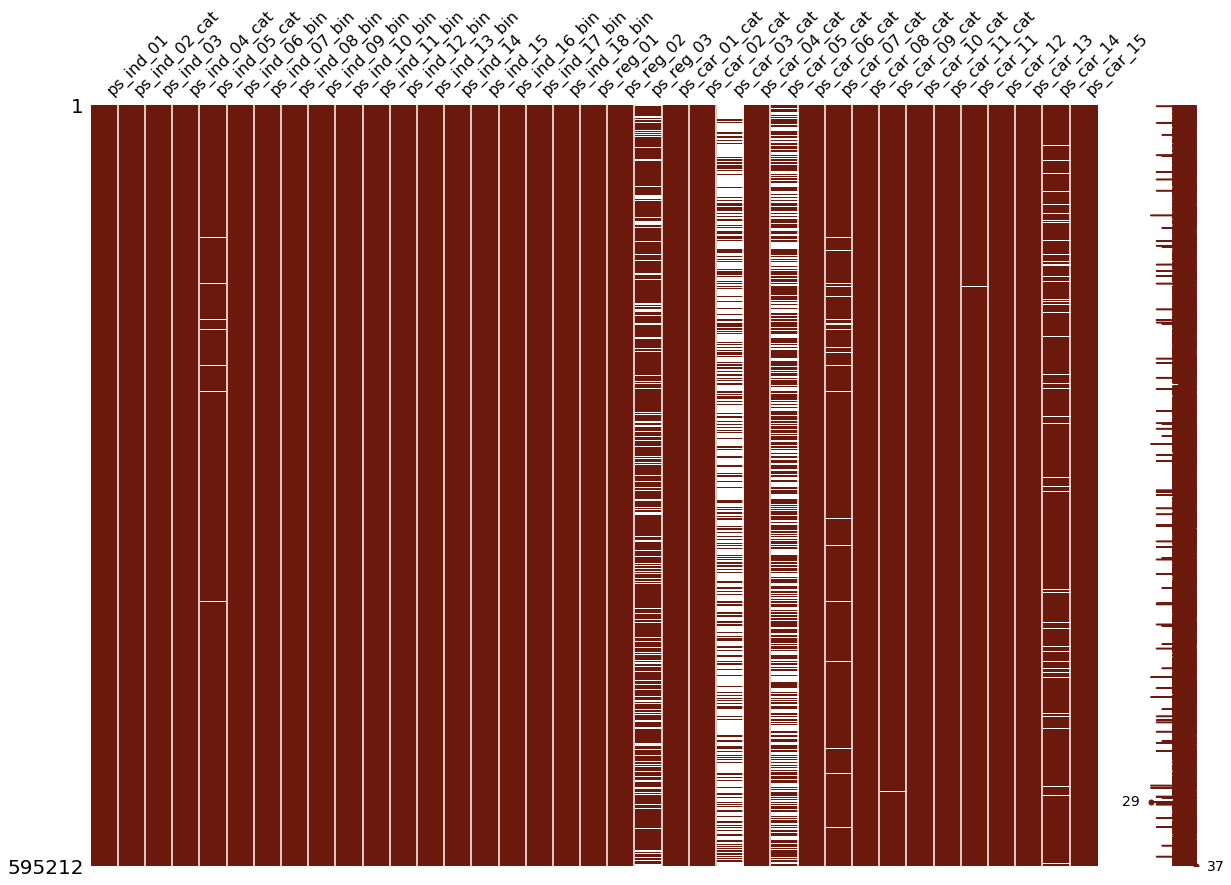

In [9]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

우리가 볼 수 있듯이, 결측값은 이제 우리가 그것을 시각화할 때 훨씬 더 명확해지고, 
여기서 수직의 어두운 빨간색 띠(결측치x) 위에 겹쳐진 빈 흰색 띠(결측치)는 특정 열에 있는 데이터의 무효를 반영한다.
이 경우, 우리는 실제로 null 값을 포함하는 59개의 총 특징 중 7개의 특징이 있다는 것을 관찰할 수 있다

=> 빨간색(결측치x), 흰색(결측치)

(Justin Nafe가 주석 섹션에서 올바르게 지적한 바와 같이 결측값이 있는 총 13개의 열이 실제로 있다). 
이는 미싱노 행렬도가 일부 열이 제외될 수 있는 하나의 그림에 약 40개의 홀수 특징에만 편안하게 적합할 수 있기 때문에 
나머지 5개의 null 열이 제외되었다. 모든 null을 시각화하려면 그림 크기 인수를 변경하고 데이터 프레임을 분할하는 방법을 조정하십시오

=> 실제론 13개의 결측치가 존재하지만 40개가 적합한 행렬도이기에 5개의 null값이 제외됨


따라서 관찰할 수 있는 7개의 null 열에 대해 다음과 같이 나열됩니다.

##### ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14



결측값의 대부분은 _cat으로 접미사가 붙은 열에서 발생합니다.

ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 주의해야 한다. 

백색 대 흑색 띠의 비율에서 볼 때, 이 세 열에서 대부분의 값이 누락되었음이 매우 분명하므로, null에 대해 -1을 완전히 대체하는 것은 그다지 좋은 전략이 아닐 수 있습니다.


### Target variable inspection


데이터에 대해 일반적으로 수행되는 또 다른 표준 점검은 우리의 대상 변수에 관한 것으로, 이 경우 열의 제목은 "대상"입니다. 

목표값은 또한 클래스/라벨/정답의 별명으로 나타나며, 이 학습된 함수가 잘 일반화 및 예측될 수 있기를 바라며 데이터를 우리의 대상에 가장 잘 매핑하는 함수를 학습하기 위해 주어진 해당 데이터와 함께 지도 학습 모델에 사용됩니다.보이지 않는 새로운 데이터가 있습니다.


In [10]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

흠, 목표 변수가 다소 불균형적이라 유의해야 할 것 같습니다. 목표물의 균형이 맞지 않는 것은 꽤 확실합니다.


### Datatype check

이 검사는 훈련 세트가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행됩니다: 

정수, 문자 또는 float. 단지 우리가 제공된 데이터에 대한 더 나은 개요를 얻기 위해서. Python 시퀀스에서 고유한 유형의 카운트를 얻기 위한 한 가지 방법은 다음과 같이 컬렉션 모듈을 가져올 때 카운터 방법을 사용하는 것입니다.


In [11]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급한 바와 같이, 훈련 데이터 세트를 구성하는 열은 총 59개이며, 본 검사에서 관찰할 수 있듯이, features/columns은 두 가지 데이터 유형인 정수 및 float으로만 구성되어 있습니다.


또 다른 주목할 점은 포르투 세구로(Porto Seguro)가 데이터에 "_bin", "_cat" 및 "_reg"와 같은 약어로 접미사가 붙은 헤더를 제공했다는 것인데, 여기서 _bin은 이진 특징을 나타내고 _cat은 범주형 특징을 나타내며 나머지는 연속 또는 순서형 특징을 나타냅니다. 여기서는 플로트 값(아마도 연속 형상만)과 정수 데이터 유형(이진, 범주형 및 순서형 형상)을 살펴봄으로써 이를 조금 더 단순화하겠습니다.


In [12]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

### Correlation plots

먼저 몇 가지 선형 상관 그림을 생성하여 기능이 다음 기능과 선형 상관 관계를 맺고 여기서 몇 가지 통찰력을 얻을 수 있도록 하겠습니다. 이 시점에서 Seaborn 통계 시각화 패키지를 사용하여 상관 관계 값의 히트맵을 그려보겠습니다. 편리하게 Panda 데이터 프레임에는 Pearson 상관 관계를 계산하는 corr() 방법이 내장되어 있습니다. 또한 상관관계도를 호출하는 Seaborn의 방식도 편리합니다. 글자 그대로 "히트맵"입니다.



#### Correlation of float features

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

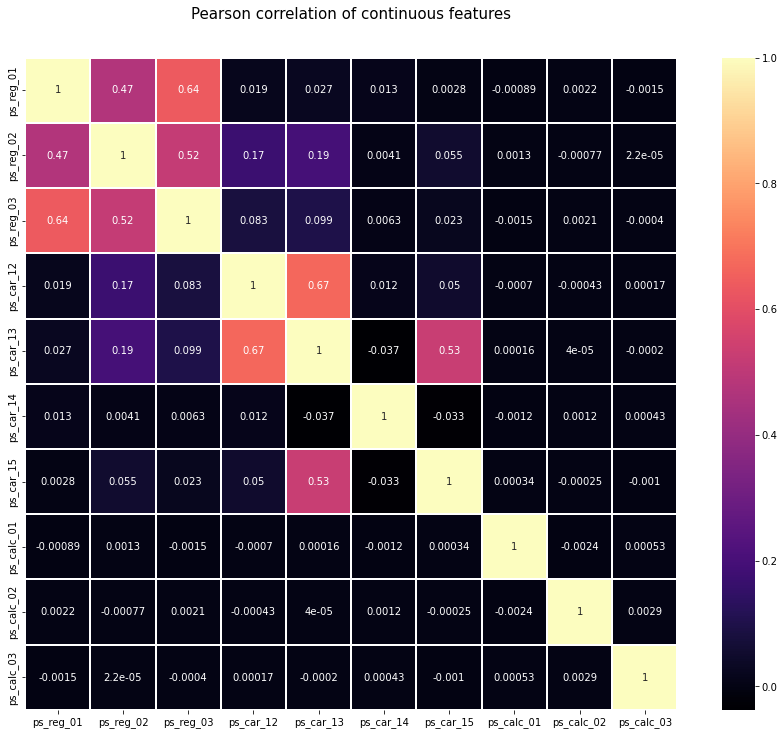

In [13]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

상관 그림을 보면 대부분의 형상이 서로 0을 표시하거나 상관 관계가 없음을 알 수 있습니다. 이것은 꽤 흥미로운 관찰로 추후 조사가 필요할 것입니다. 지금은 양의 선형 상관 관계를 표시하는 쌍 기능이 다음과 같이 나열됩니다.


(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)



#### Correlation of integer features



integer 유형 열의 경우 상호 작용적으로 상관 관계 값의 열 지도를 생성하는 방법을 보여주기 위해 플롯리 라이브러리를 사용하는 것으로 전환하겠습니다. 
이전의 플롯리 플롯과 마찬가지로 "go.heatmap"을 호출하여 열 지도 개체를 생성합니다. 
여기서는 세 개의 다른 축에 값을 제공해야 합니다. 여기서 x축과 y축은 열 이름을 사용하고 z축은 상관 값을 제공합니다. 
색상 척도 속성은 열 지도에서 볼 수 있는 다양한 색상 팔레트에 해당하는 키워드를 사용합니다. 
이 예에서는 Greys 색상 스케일을 사용했습니다(다른 색상에는 Portland 및 Viridis가 포함되어 있습니다. 직접 사용해 보십시오).


In [14]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

마찬가지로, 상관 그림에서 상당히 많은 0 값 셀을 관찰하는 것으로 보아 서로 선형 상관 관계가 없는 열이 매우 많다는 것을 알 수 있습니다.
이는 특히 주성분 분석(PCA)과 같은 차원 감소 변환을 수행하려고 하는 경우 어느 정도의 상관 관계가 필요합니다.
몇 가지 관심 기능은 다음과 같습니다.


Negatively correlated features : ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

한 가지 흥미로운 점은 무효성에 대한 이전 분석에서 ps_car_03_cat 및 ps_car_05_cat에 결측값 또는 null 값이 많이 포함되어 있다는 것입니다. 따라서 이러한 두 기능이 데이터에 대한 기본 정보를 실제로 반영하지 않더라도 서로 상당히 강한 양의 선형 상관 관계를 보인다는 것은 놀랄 일이 아닙니다.


## Mutual Information plots


상호 정보는 대상 변수와 대상 변수가 계산되는 해당 특성 사이의 상호 정보를 검사할 수 있기 때문에 또 다른 유용한 도구입니다. 
분류 문제의 경우 두 랜덤 변수 사이의 의존성을 측정하고 0(임의 변수가 서로 독립적인 경우)에서 더 높은 값(일부 의존성을 나타냄)까지 측정하는 Sklearn의 mutual_info_classif 방법을 편리하게 호출할 수 있습니다.
따라서 대상으로부터 얼마나 많은 정보가 기능 내에 포함될 수 있는지 파악할 수 있습니다.


mutual_info_classif 함수의 sklearn 구현은 "k-근접 이웃 거리의 엔트로피 추정에 기초한 비모수 방법과 관련이 있다"고 알려주며, 여기서 더 자세한 내용은 링크의 공식 sklearn 페이지에서 확인할 수 있습니다.


In [15]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


### Binary features inspection

데이터의 또 다른 측면으로는 이진수 값만 포함하는 열(즉, 값이 두 값 1 또는 0 중 하나만을 차지함)이 있습니다. 
계속해서 이러한 이진수 값이 포함된 모든 열을 저장한 다음 다음과 같이 이진수 값에 대한 수직 플롯 막대 그림을 생성합니다.


In [16]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [17]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)

trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

여기서는 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지 특징이 0에 의해 완전히 지배된다는 것을 관찰합니다.
이는 이러한 기능이 대상에 대한 다른 클래스에 대한 정보를 많이 포함하지 않기 때문에 유용한지 여부에 대한 의문을 제기합니다.


### Categorical and Ordinal feature inspection

먼저 접미사 "_cat"에 따라 범주형이라고 하는 특징을 살펴보겠습니다.

### Feature importance via Random Forest

이제 랜덤 포레스트 분류기로 훈련 데이터를 맞추고 모델이 훈련을 마친 후 특징의 순위를 살펴보는 랜덤 포레스트 모델을 구현하겠습니다. 이것은 유용한 기능 중요성을 얻는 데 많은 매개변수 조정이 필요하지 않고 대상 불균형에도 매우 강력한 앙상블 모델(Bootstrap Aggregate 아래에 적용되는 약한 의사 결정 트리 학습자의 앙상블)을 사용하는 빠른 방법입니다. 랜덤 포리스트를 다음과 같이 부릅니다.


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


#### Plot.ly Scatter Plot of feature importances

랜덤 포리스트를 학습하면 "featureimportances" 속성을 호출하여 변수 중요도 목록을 얻고 다음 플롯리 플롯인 산점도를 그릴 수 있습니다.

여기서는 Scatter 명령을 호출하고 이전의 플롯리 플롯에 따라 y축과 x축을 정의해야 합니다. 

그러나 산점도에서 주의해야 할 한 가지는 마커 속성입니다. 이것은 내장된 산포점의 크기, 색상 및 스케일을 정의하는 마커 속성입니다.

In [22]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)

data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

또한 다음과 같이 동일한 플롯 막대 그림을 통해 중요도 순서에 따라 순위가 매겨진 모든 형상의 정렬된 목록을 표시할 수 있습니다.

In [23]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualisation



자주 사용되는 다른 흥미로운 트릭 또는 기술은 나뭇가지나 모델에 의해 만들어진 결정을 시각화하는 것입니다. 단순화를 위해 의사 결정 트리(max_depth = 3)를 적합시키므로 의사 결정 분기에는 3개의 수준만 표시됩니다. sklearn에서 내보내기를 사용하여 "export_graphviz"를 학습한 다음 이 노트북에서 시각화를 위해 트리 이미지를 내보내고 가져옵니다.


In [38]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("./tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree2.png'])

# Annotating chart with PIL
img = Image.open("./tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

### Feature importance via Gradient Boosting model

단지 궁금해서, 우리의 특징에 대한 중요성을 얻기 위해 다른 학습 방법을 시도해보도록 해요. 이번에는 Gradient Boosting 분류기를 사용하여 교육 데이터에 맞춥니다. Gradient Boosting은 각 단계에서 손실 함수의 기울기에 맞춰집니다(Sklearn 구현의 이탈로 기본 설정됨).

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [34]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [35]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

흥미롭게도 랜덤 포레스트와 그라데이션 부스트 학습 모델 모두에서 두 모델 모두 선택한 가장 중요한 특징은 열 ps_car_13입니다.


## Conclusion

우리는 Null 값과 데이터 품질을 검사하여 Porto Seguro 데이터 세트에 대한 꽤 광범위한 검사를 수행했고, 특징 간의 선형 상관 관계를 조사했으며, 특징 분포의 일부를 검사했으며, 다음과 같은 특징을 식별하기 위해 몇 가지 학습 모델(Random Forest 및 Gradient Boosting 분류기)을 구현했습니다. 중요하다고 판단되는 모델입니다.
